# Analyse des Restaurants et Visualisations

Ce notebook analyse les données de notation des restaurants et crée des visualisations pour mieux comprendre les tendances.

L'analyse se concentre sur plusieurs aspects :
- Les scores par type de cuisine
- Les corrélations entre différentes notes
- L'impact du budget sur les notes
- La relation entre le nombre d'avis et les scores

In [11]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration du style des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 1. Chargement et Préparation des Données

Nous utilisons un fichier CSV 'Cuisine_rating.csv' qui contient les données suivantes :
- Notes de la nourriture (Food Rating)
- Notes du service (Service Rating)
- Notes globales (Overall Rating)
- Type de cuisine (Cuisines)
- Budget

In [12]:
# Chargement des données
df = pd.read_csv('Cuisine_rating.csv')

# Affichage des premières lignes
print("Aperçu des données :")
display(df.head())

# Informations sur le dataset
print("\nInformations sur le dataset :")
display(df.info())

Aperçu des données :


,User ID,Area code,Location,Gender,YOB,Marital Status,Activity,Budget,Cuisines,Alcohol,Smoker,Food Rating,Service Rating,Overall Rating,Often A S
0,1,153,"Upper East Side,NY",Female,2006,Single,Professional,3,Japanese,Never,Never,5,4,4.5,No
1,2,123,"St. George,NY",Female,1991,Married,Student,3,Indian,Never,Socially,1,1,1.0,No
2,3,122,"Upper West Side,NY",Male,1977,Single,Student,5,Seafood,Often,Often,5,5,5.0,Yes
3,4,153,"Upper East Side,NY",Female,1956,Married,Professional,5,Japanese,Never,Socially,3,1,2.0,No
4,5,129,"Central Park,NY",Male,1997,Single,Student,4,Filipino,Socially,Never,2,4,3.0,No



Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   User ID         200 non-null    int64  
 1   Area code       200 non-null    int64  
 2   Location        200 non-null    object 
 3   Gender          200 non-null    object 
 4   YOB             200 non-null    int64  
 5   Marital Status  200 non-null    object 
 6   Activity        200 non-null    object 
 7   Budget          200 non-null    int64  
 8   Cuisines        200 non-null    object 
 9   Alcohol         200 non-null    object 
 10  Smoker          200 non-null    object 
 11  Food Rating     200 non-null    int64  
 12  Service Rating  200 non-null    int64  
 13  Overall Rating  200 non-null    float64
 14  Often A S       200 non-null    object 
dtypes: float64(1), int64(6), object(8)
memory usage: 23.6+ KB


None

## 2. Calcul des Scores

La fonction `calculate_cuisine_scores` calcule un score pondéré pour chaque type de cuisine en prenant en compte :

1. Les différentes notes avec les pondérations suivantes :
   - Note globale : 40%
   - Note de la nourriture : 40%
   - Note du service : 20%

2. Un facteur de popularité basé sur le nombre d'avis
   - Utilisation de log(1 + nombre_avis) pour réduire l'impact des valeurs extrêmes
   - Le facteur de popularité augmente le score de 0% à ~23% pour les restaurants les plus notés

In [13]:
def calculate_cuisine_scores(df):
    cuisine_scores = df.groupby('Cuisines').agg({
        'Food Rating': 'mean',
        'Service Rating': 'mean',
        'Overall Rating': 'mean'
    }).round(2)

    cuisine_counts = df['Cuisines'].value_counts()
    cuisine_scores['Number_of_Ratings'] = cuisine_counts

    cuisine_scores['Weighted_Score'] = (
        cuisine_scores['Overall Rating'] * 0.4 +
        cuisine_scores['Food Rating'] * 0.4 +
        cuisine_scores['Service Rating'] * 0.2
    ) * (1 + np.log1p(cuisine_scores['Number_of_Ratings']) / 10)

    return cuisine_scores.round(2)

### Résultats des Scores

Le tableau ci-dessous présente les scores calculés pour chaque type de cuisine, triés par score pondéré décroissant.
Les scores prennent en compte à la fois la qualité (notes) et la popularité (nombre d'avis).

In [14]:
# Calcul des scores
cuisine_scores = calculate_cuisine_scores(df)
display(cuisine_scores.sort_values('Weighted_Score', ascending=False))

,Food Rating,Service Rating,Overall Rating,Number_of_Ratings,Weighted_Score
Cuisines,,,,,
Japanese,3.86,3.33,3.60,36,4.97
Chinese,3.46,3.08,3.27,24,4.37
French,3.29,2.91,3.10,34,4.25
Indian,2.78,3.56,3.17,32,4.17
Seafood,3.23,3.05,3.14,22,4.15
Italian,3.22,3.17,3.19,18,4.14
Filipino,2.71,3.38,3.04,34,4.03


## 3. Visualisations

### 3.1 Scores par Type de Cuisine

Le graphique suivant montre les scores pondérés pour chaque type de cuisine.
Les cuisines sont classées de la meilleure à la moins bien notée.

<Figure size 1200x600 with 0 Axes>

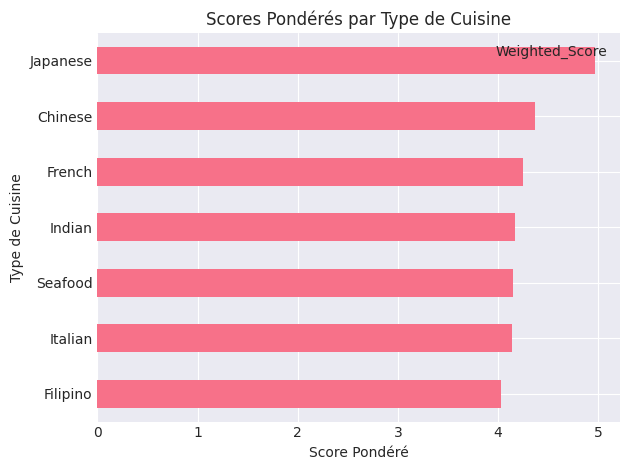

In [15]:
plt.figure(figsize=(12, 6))
cuisine_scores.sort_values('Weighted_Score', ascending=True).plot(
    kind='barh',
    y='Weighted_Score',
    title='Scores Pondérés par Type de Cuisine'
)
plt.xlabel('Score Pondéré')
plt.ylabel('Type de Cuisine')
plt.tight_layout()

### 3.2 Carte Thermique des Corrélations

Cette visualisation montre les corrélations entre les différentes notes :
- Food Rating vs Service Rating
- Overall Rating vs autres notes
- Impact sur le score pondéré final

Text(0.5, 1.0, 'Corrélations entre les Différentes Notes')

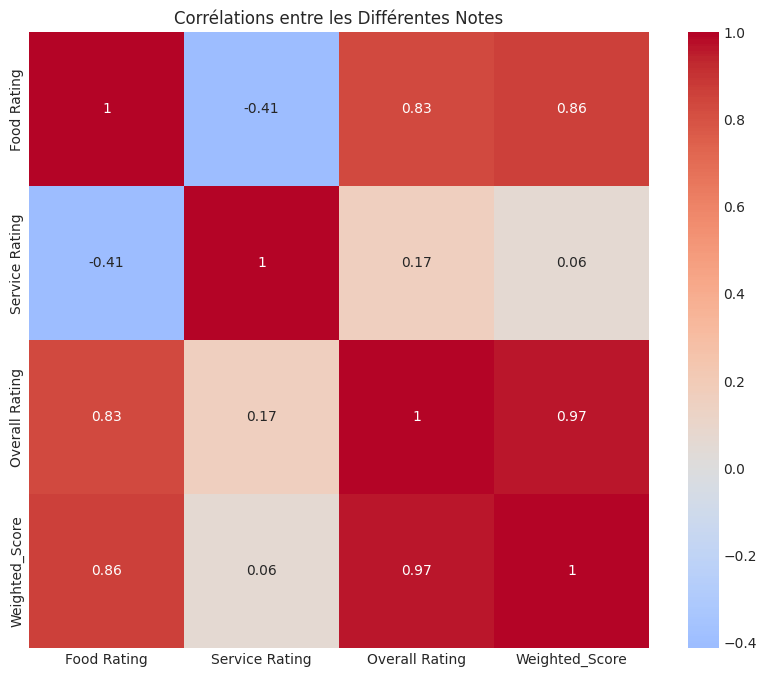

In [16]:
plt.figure(figsize=(10, 8))
correlation_matrix = cuisine_scores[['Food Rating', 'Service Rating', 'Overall Rating', 'Weighted_Score']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Corrélations entre les Différentes Notes')

### 3.3 Analyse par Budget

<Figure size 1000x600 with 0 Axes>

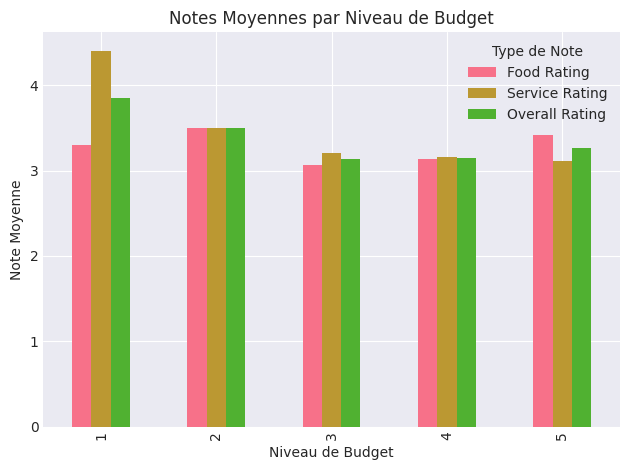

In [17]:
budget_analysis = df.groupby('Budget').agg({
    'Food Rating': 'mean',
    'Service Rating': 'mean',
    'Overall Rating': 'mean'
}).round(2)

plt.figure(figsize=(10, 6))
budget_analysis.plot(
    kind='bar',
    title='Notes Moyennes par Niveau de Budget'
)
plt.xlabel('Niveau de Budget')
plt.ylabel('Note Moyenne')
plt.legend(title='Type de Note')
plt.tight_layout()

### 3.4 Analyse des Relations

/tmp/ipykernel_18645/2695134695.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (cuisine_scores['Number_of_Ratings'][i],
/tmp/ipykernel_18645/2695134695.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cuisine_scores['Weighted_Score'][i]))


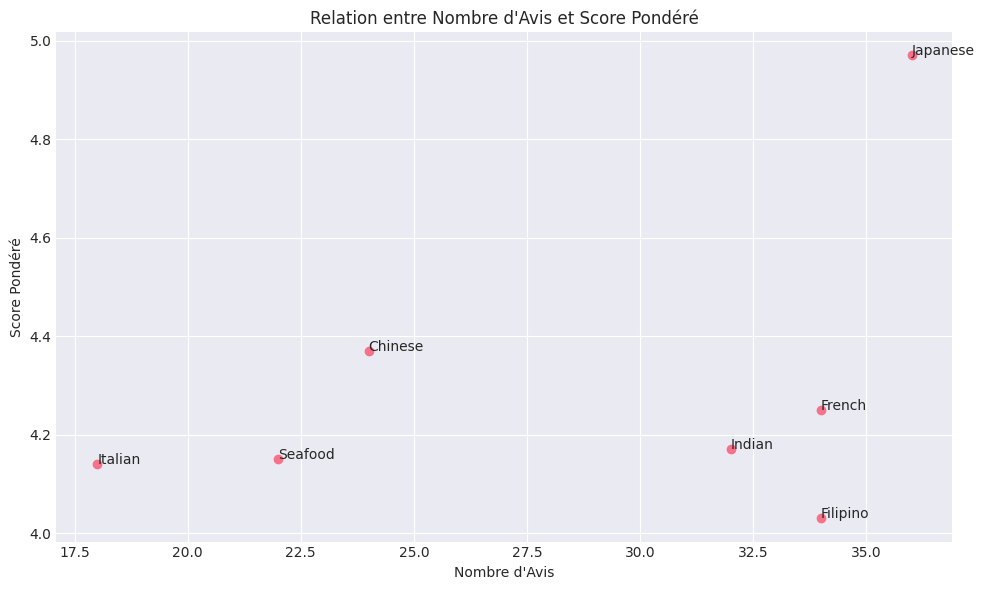

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(cuisine_scores['Number_of_Ratings'], cuisine_scores['Weighted_Score'])
plt.xlabel('Nombre d\'Avis')
plt.ylabel('Score Pondéré')
plt.title('Relation entre Nombre d\'Avis et Score Pondéré')

for i, cuisine in enumerate(cuisine_scores.index):
    plt.annotate(cuisine,
                (cuisine_scores['Number_of_Ratings'][i],
                 cuisine_scores['Weighted_Score'][i]))
plt.tight_layout()

## 4. Analyses Supplémentaires

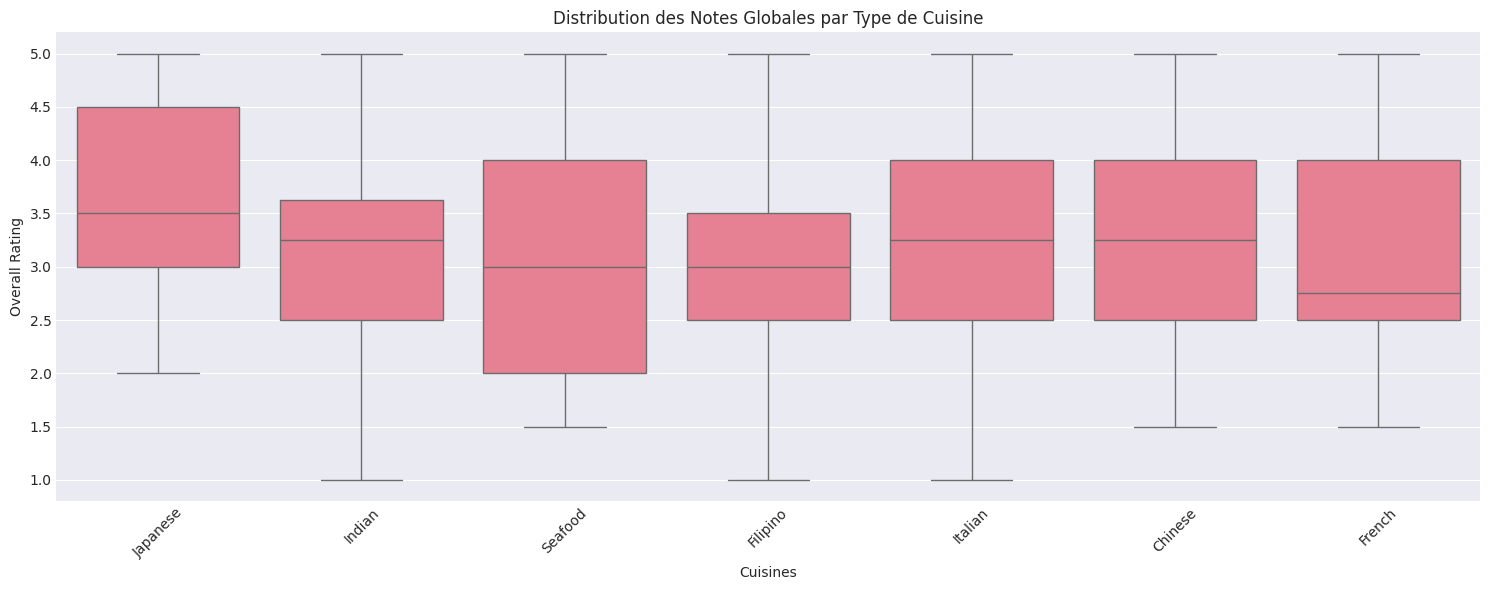

In [19]:
# Distribution des notes par type de cuisine
plt.figure(figsize=(15, 6))
sns.boxplot(x='Cuisines', y='Overall Rating', data=df)
plt.xticks(rotation=45)
plt.title('Distribution des Notes Globales par Type de Cuisine')
plt.tight_layout()